# PI-CAI dataset exploration

In [14]:
import os
from os.path import join
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import SimpleITK as sitk


from DataAnalyzer import DataAnalyzer
from time import perf_counter

DATA_ROOT = "/home/guest/work/Datasets"

paths = {
    "picai_labels_wg" : "picai_labels_all/picai_labels-main/anatomical_delineations/whole_gland/AI/Guerbet23",
    "picai_labels_zonal" : "picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23",
    "picai_folds" : "picai_folds/picai_images_fold0"
}

analyzer = DataAnalyzer(DATA_ROOT)


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

We see some patitent cases that have additional images (more than one study was performed on them).

In [15]:
pth = os.path.join(paths["picai_folds"])
folds = analyzer.get_dirs(pth)

for fold in folds:
    rel = os.path.join(pth, fold)
    dirs = analyzer.get_dirs(rel)
    incomplete_dirs = []
    total = 0

    for dir in dirs:
        # check if they all have 5 files
        rel2 = os.path.join(rel, dir)
        
        files = analyzer.get_files(rel2)

        if len(list(files)) != 5:
            print(f"Directory {dir} has {
                # do this because the analyzer returns a generator
                len(list(analyzer.get_files(rel2)))} files, expected 5.")
            incomplete_dirs.append(dir)
        total += 1

    print(f"Number of non-matching directories: {len(incomplete_dirs)}")

    print("Total file count excluding the previous non-matching: ", (total - len(incomplete_dirs) ) * 5)



Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file c

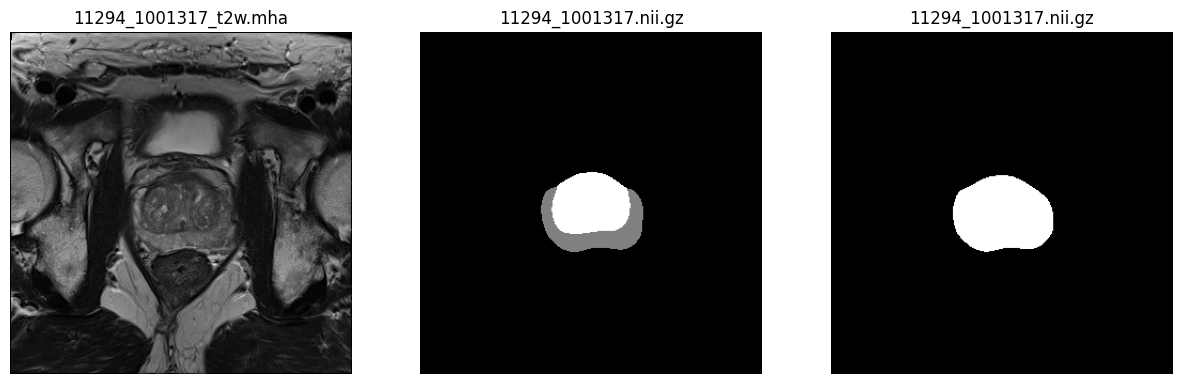

In [16]:

# pick a random folder and set the name of a file inside as the prefix
dirs = list(analyzer.get_dirs(paths["picai_folds"]))
random_dir = random.choice(dirs)
files_in_dir = analyzer.get_files(join(paths["picai_folds"], random_dir), ".*_t2w.mha$")

# we have to do this because get files is a generator
name = next(files_in_dir)
i1 = join(paths["picai_folds"], random_dir, name)

# get the corresponding nii.gz file that masks the image
nii = name.split("_t2w")[0].split("/")[-1] + ".nii.gz"
i2 = join(paths['picai_labels_zonal'], nii)

# get the whole gland mask
i3 = join(paths['picai_labels_wg'], nii)

analyzer.show_image(i1, i2, i3, save="/home/guest/code")


Let's look for possible empty masks, since some of the lesion data was missing

In [17]:
analyzer.regex = r".*mha$"
non_empty_count, empty_masks = analyzer.count_and_find_non_empty_masks(paths['picai_labels_zonal'])
print(f"{non_empty_count} out of {non_empty_count+len(empty_masks)} masks are non-empty (contain a segmentation).")
print("Empty mask files:", empty_masks)

0 out of 0 masks are non-empty (contain a segmentation).
Empty mask files: []


Is the whole gland the sum of the zonal masks?

A we see th ewhole gland is sligtly bigger in most cases, indicating it's not just the sum. 
This might be due to differences in the model used for automatic labeling.

As mentioned in the PICAI dataset, the anatomical anottations are made automatically, and furthermore they use different algorithms for whole gland and zonal segmentation.
Therefore, there might be some differences in the whole gland and zonal masks. 

/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10177_1000180.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11128_1001151.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10648_1000664.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11177_1001200.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10003_1000003.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11335_1001358.nii.gz


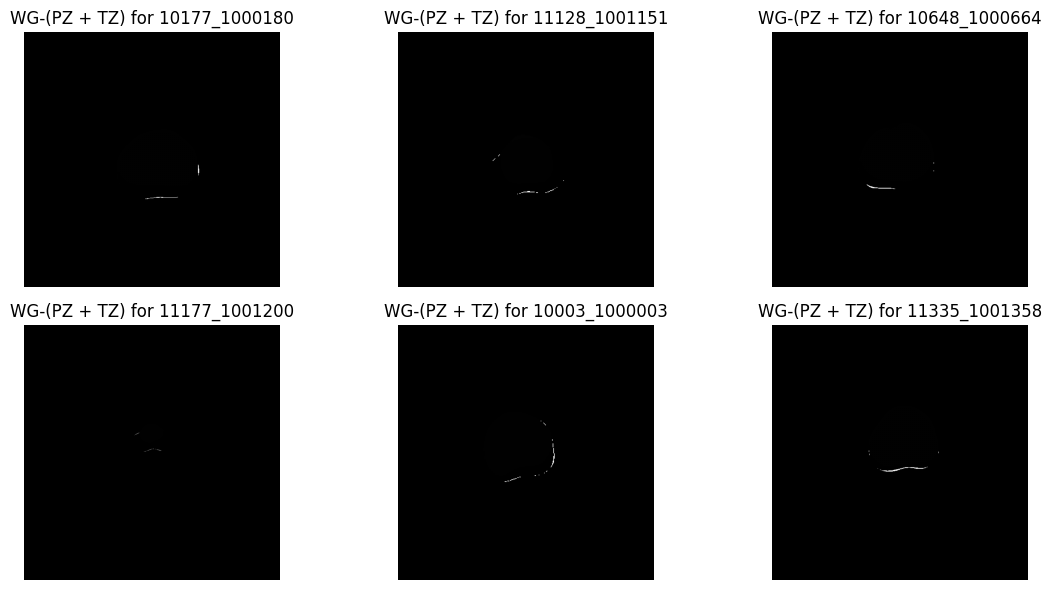

In [18]:

# pick a random folder and set the name of a file inside as the prefix
d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=6)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Create a 3x2 figure with axes
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = next(files_in_dir)

    # Get the corresponding nii.gz file that masks the image
    nii = os.path.basename(name).split("_t2w")[0] + ".nii.gz"
    i2 = join(DATA_ROOT, paths['picai_labels_zonal'], nii)
    print(i2)


    # Get the whole gland mask
    i3 = join(DATA_ROOT, paths['picai_labels_wg'], nii)

    # Turn the images into arrays, set all labels >= 1 to 1
    # Then, do the difference between both and display it to see where they differ
    i2 = sitk.ReadImage(i2)
    image_array = sitk.GetArrayViewFromImage(i2)
    image_array[image_array >= 1]
    #print(image_array[image_array.shape[0] // 2, :, :])

    i3 = sitk.ReadImage(i3)
    i3_array = sitk.GetArrayViewFromImage(i3)
    i3_array[i3_array >= 1]
    #print(i3_array[i3_array.shape[0] // 2, :, :])

    diff = (image_array - i3_array)
    diff[diff >= 1] # Keep only positive differences
    diff = diff[image_array.shape[0] // 2, :, :] # take the middle slice by default
    
    # Plot the image diff on the corresponding axis
    axes[idx].imshow(diff, cmap='gray')
    axes[idx].set_title(f"WG-(PZ + TZ) for {os.path.basename(name).split('_t2w')[0]}")
    axes[idx].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#analyzer.show_image(i2, i3, save="../combined_images.png")

Now, we use the function the analyzer to analyze the metadata.

In [19]:
# use this regex to filter the files
analyzer.regex = "(.*_t2w.mha$)|(.*_sag.mha$)|(.*_cor.mha$)"
res = analyzer.collect_metadata_to_dataframe("picai_folds/picai_images_fold0/10189")
print(res)

start = perf_counter()
df = analyzer.collect_metadata_from_subdirs("picai_folds/picai_images_fold0")
print(df)
print(perf_counter() - start, "seconds")

                filename        dim_size              spacing orientation  \
0  10189_1000192_cor.mha  (320, 320, 19)      (0.6, 0.6, 3.6)         RSA   
1  10189_1000192_t2w.mha  (640, 640, 21)      (0.3, 0.3, 3.6)         RAI   
2  10189_1000192_sag.mha  (320, 320, 21)  (0.562, 0.562, 3.6)         ASL   

   prostate_volume   vendor    mri_name  psa_report  
0            125.0  SIEMENS  Prisma_fit        5.97  
1            125.0  SIEMENS  Prisma_fit        5.97  
2            125.0  SIEMENS  Prisma_fit        5.97  
                  filename        dim_size              spacing orientation  \
0    10961_1000980_t2w.mha  (384, 384, 21)      (0.5, 0.5, 3.0)         RAI   
1    10961_1000980_sag.mha  (320, 320, 19)  (0.562, 0.562, 3.6)         ASL   
2    10961_1000980_cor.mha  (320, 320, 17)      (0.6, 0.6, 3.0)         RSA   
3    10851_1000867_t2w.mha  (384, 384, 21)      (0.5, 0.5, 3.0)         RAI   
4    10851_1000867_sag.mha  (320, 320, 19)  (0.562, 0.562, 3.6)         ASL   
.

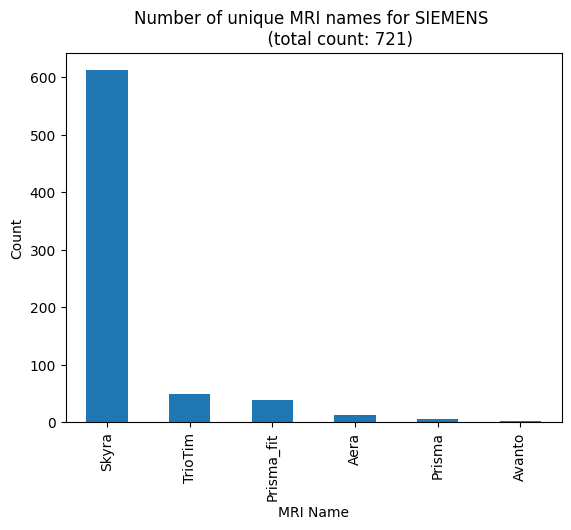

In [20]:
# for all the rows with vendor SIEMENS, get number of unique mri_names
siemens_mri_names = df[df['vendor'] == 'SIEMENS']['mri_name'].value_counts()

import matplotlib.pyplot as plt
siemens_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for SIEMENS 
          (total count: {})""".format(siemens_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

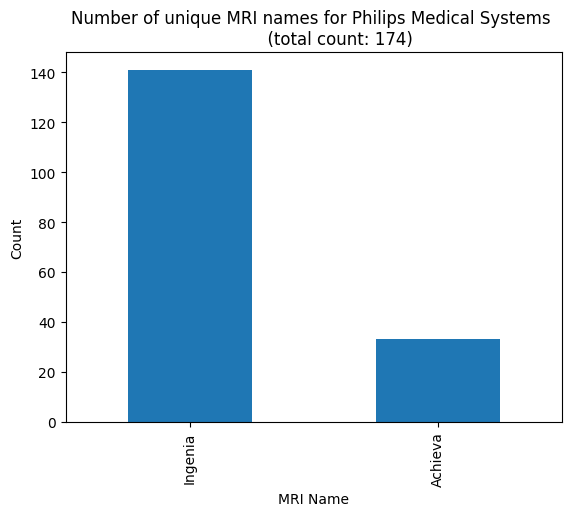

In [21]:
# for all the rows with vendor Philips Medical Systems, get number of unique mri_names
phl_mri_names = df[df['vendor'] == 'Philips Medical Systems']['mri_name'].value_counts()

# plot in a bar graph
import matplotlib.pyplot as plt
phl_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for Philips Medical Systems 
          (total count: {})""".format(phl_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

Now, we are interested in the dimensons and resolutions of the data, and how they are distrubuted trough the dataset.

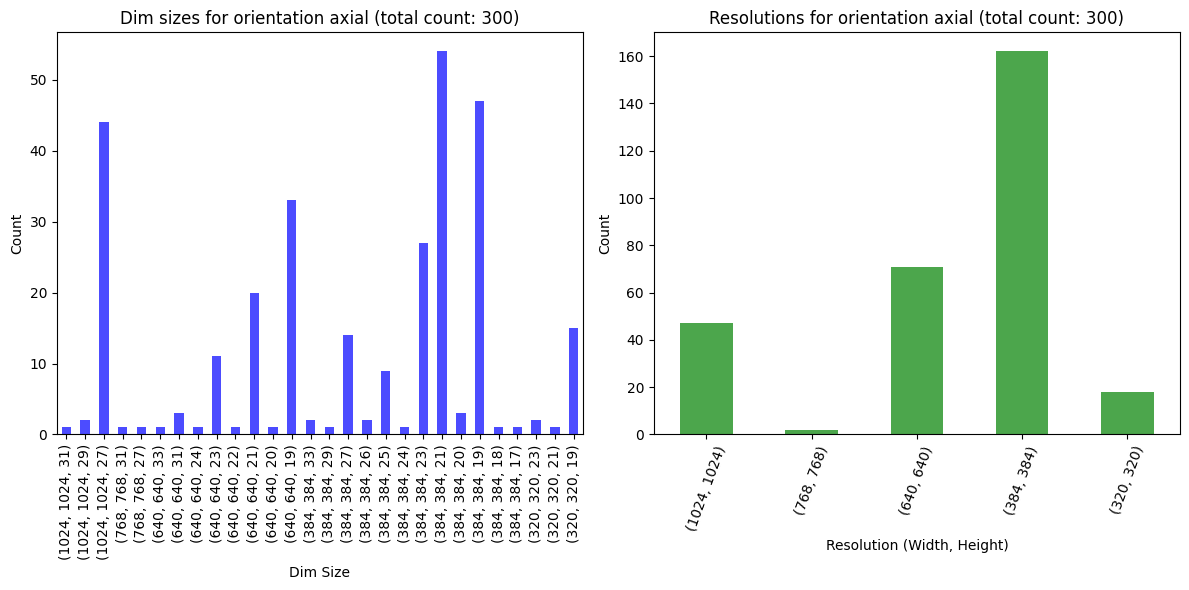

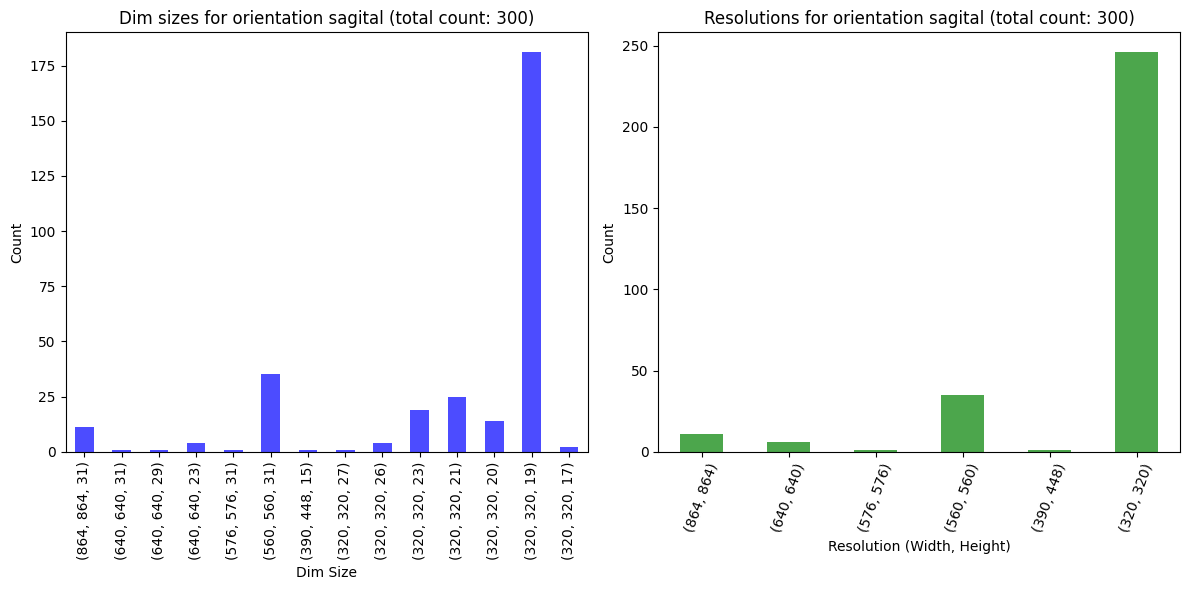

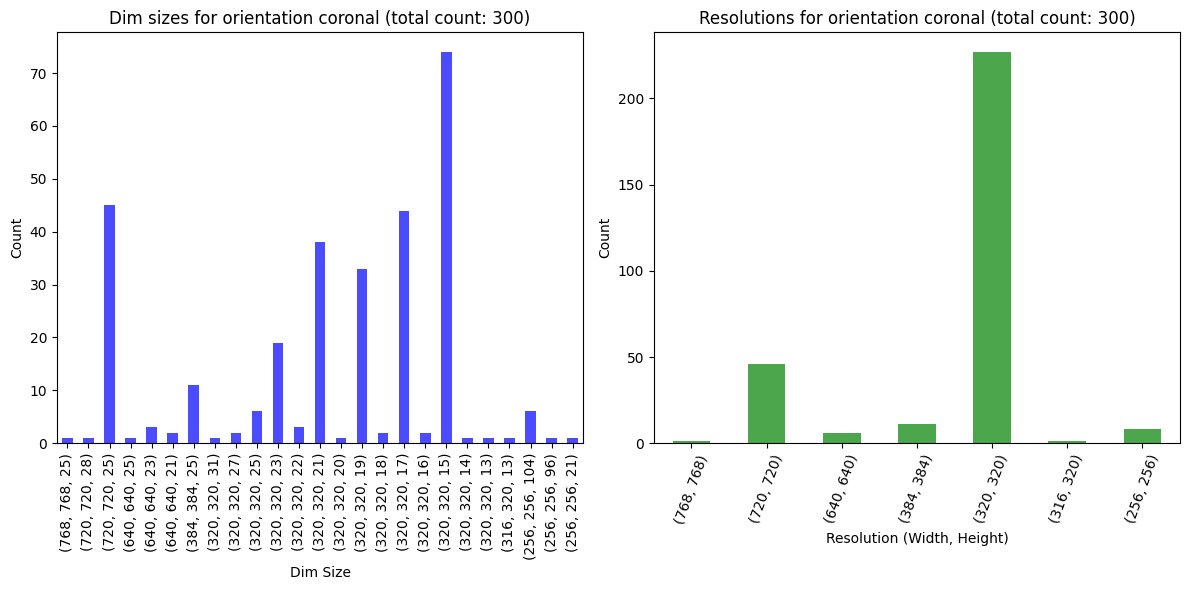

In [22]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    # Obtener el conteo de dim_size y ordenarlo
    dim_sizes = orientation_df['dim_size'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['dim_size']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )
    
    # Crear dos gráficos separados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Dos gráficos lado a lado

    # Primer gráfico: dim_size
    dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title(f"Dim sizes for orientation {value} (total count: {dim_sizes.sum()})")
    ax1.set_xlabel("Dim Size")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title(f"Resolutions for orientation {value} (total count: {resolution_counts.sum()})")
    ax2.set_xlabel("Resolution (Width, Height)")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=70)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We will do a similar thing as the previous step, but now we will use the spacing data to see the voxel size of the images.

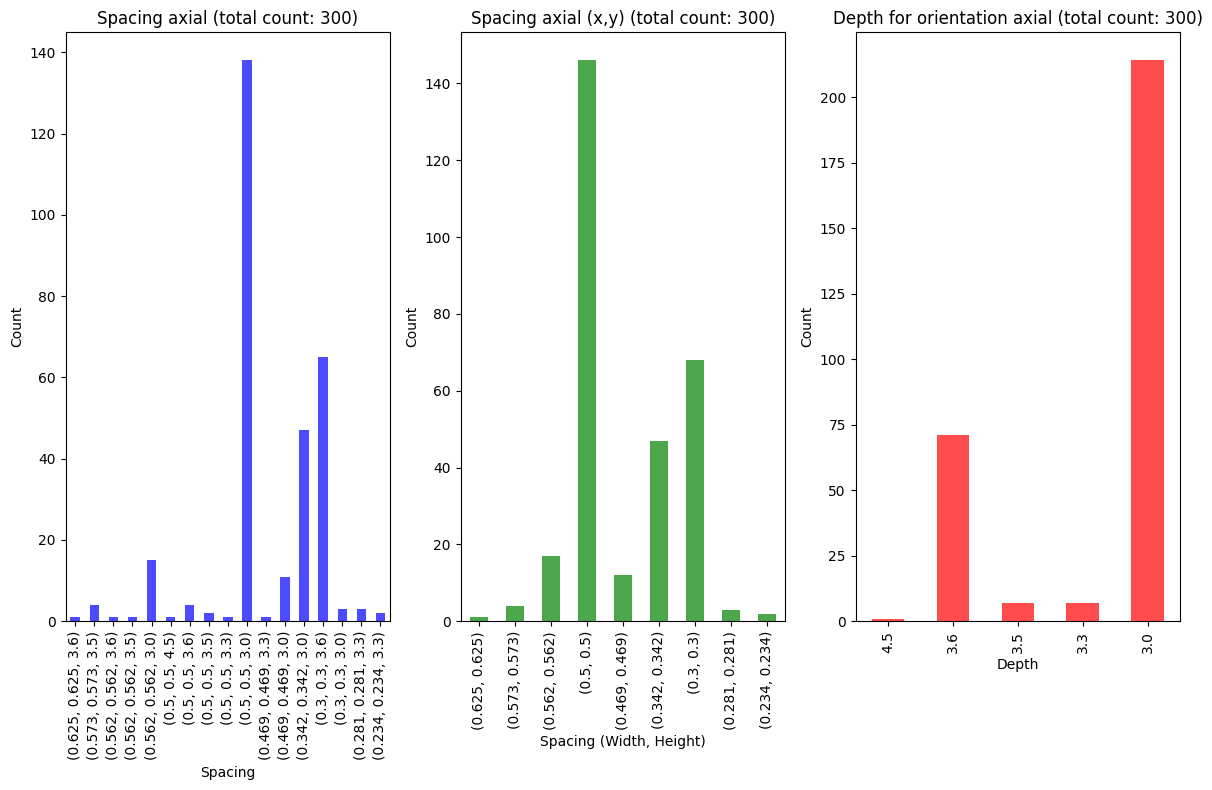

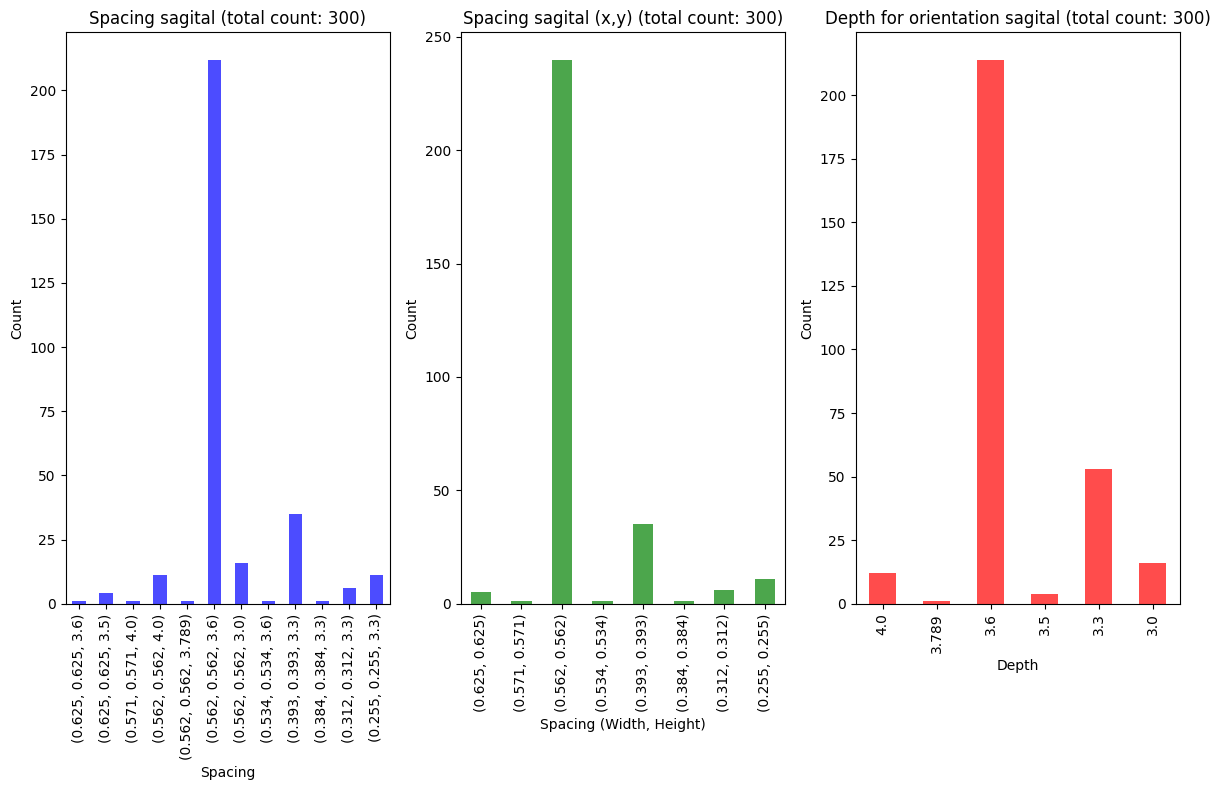

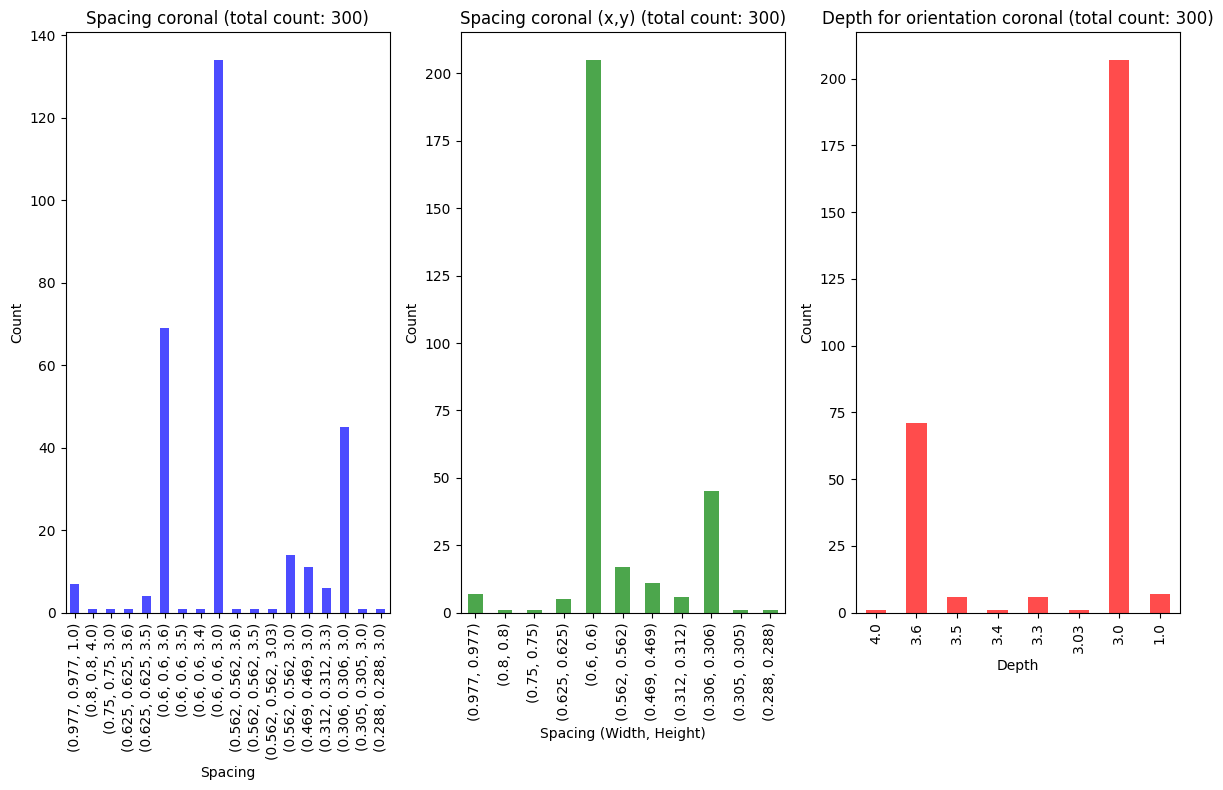

In [23]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    dim_sizes = orientation_df['spacing'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )

    # agrupar por la profundidad de la imagen
    depth_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[2]))  # Extraer solo la profundidad
        .value_counts()
        .sort_index(ascending=False)
    )
    
    
    # Crear dos gráficos separados
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))  # Dos gráficos lado a lado

    # Primer gráfico: dim_size
    dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title(f"Spacing {value} (total count: {dim_sizes.sum()})")
    ax1.set_xlabel("Spacing")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title(f"Spacing {value} (x,y) (total count: {resolution_counts.sum()})")
    ax2.set_xlabel("Spacing (Width, Height)")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=90)

    # Tercer gráfico: profundidad
    depth_counts.plot(kind='bar', ax=ax3, color='red', alpha=0.7)
    ax3.set_title(f"Depth for orientation {value} (total count: {depth_counts.sum()})")
    ax3.set_xlabel("Depth")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=90)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We must also check the image pixel intensities for normalization.

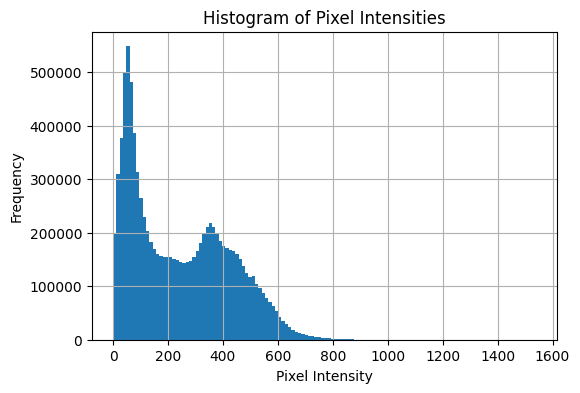

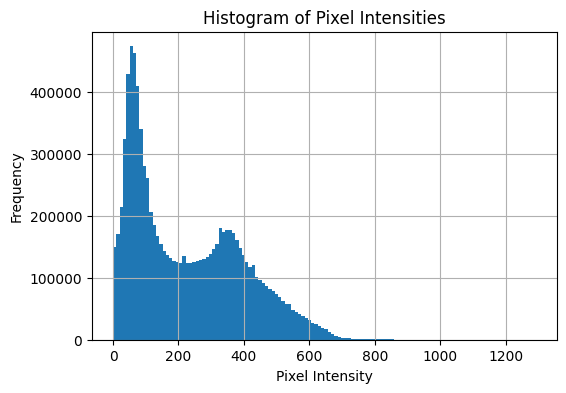

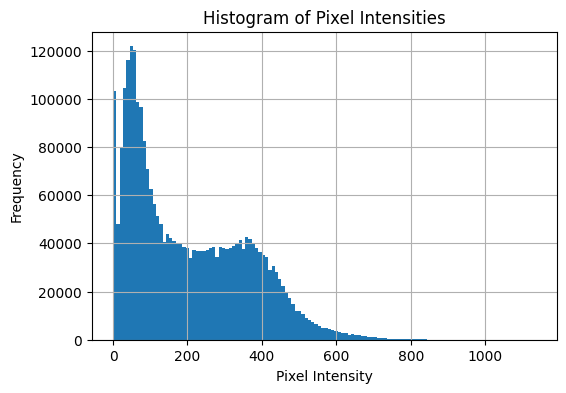

In [24]:
# plot pixel intensity histograms for a random selection of images

d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=3)


for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = list(files_in_dir)[0]
    i1 = join(d, dir, name)

    analyzer.image_intensity_histogram(i1, plot = True)    

We need to know an approximate image center around which we will set the ROI. 
Let's get info from the masks, the mean center and size so that wa can use it for setting a ROI "bounding box" value.

In [193]:
def find_bounding_box(mask_path):

    # read mask image
    mask = sitk.ReadImage(mask_path)

    # Convert mask to numpy array and find nonzero coordinates
    mask_array = sitk.GetArrayFromImage(mask)
    coords = np.argwhere(mask_array > 0) # we remove the slices with no segmentation
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)

    # Compute center of the mask in array coordinates 
    center = ((min_coords + max_coords) / 2).astype(int)

    # Compute the maximum extent (span) in any direction
    extent = (max_coords - min_coords).max()    

    # Ensure box_size is odd for symmetry (optional)
    #box_size = extent + 1 if extent % 2 == 0 else extent
    box_size = extent

    # Compute start and end indices for each axis
    half_size = box_size // 2
    shape = np.array(mask_array.shape)
    min_box = center - half_size
    max_box = center + half_size

    # Clip to image bounds
    min_box = np.maximum(min_box, 0)
    max_box = np.minimum(max_box, shape - 1)

    # Recompute size in case box was clipped
    size = max_box - min_box + 1

    # get x, y, z order for size and index
    start = [int(x) for x in min_box[::-1]]
    size = [int(s) for s in size[::-1]]

    return start, size, center[::-1], extent, shape[::-1], mask_path

In [ ]:
import concurrent.futures
# we use concurrency te prevent too many sequential reads of the files which can be slow

parent_dir = join(DATA_ROOT, paths["picai_labels_wg"])
cpus = os.cpu_count()

with concurrent.futures.ProcessPoolExecutor(
    max_workers=cpus
) as executor:
    records = list(
        executor.map(find_bounding_box, 
        analyzer.get_files(parent_dir, ".*\.nii\.gz$"))
    )
df = pd.DataFrame(records, columns=['start', 'size', 'center', 'extent', 'shape', 'mask_path'])
df

<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1024623/4235442059.py:12: SyntaxWarning: invalid escape sequence '\.'
  analyzer.get_files(parent_dir, ".*\.nii\.gz$"))


,start,size,center,extent,shape,mask_path
0,"[163, 167, 0]","[285, 285, 23]","[305, 309, 10]",284,"[640, 640, 23]",/home/guest/work/Datasets/picai_labels_all/pic...
1,"[144, 162, 0]","[93, 93, 21]","[190, 208, 10]",92,"[384, 384, 21]",/home/guest/work/Datasets/picai_labels_all/pic...
2,"[150, 142, 0]","[85, 85, 23]","[192, 184, 13]",84,"[384, 384, 23]",/home/guest/work/Datasets/picai_labels_all/pic...
3,"[230, 250, 0]","[199, 199, 21]","[329, 349, 9]",199,"[640, 640, 21]",/home/guest/work/Datasets/picai_labels_all/pic...
4,"[295, 279, 0]","[165, 165, 27]","[377, 361, 10]",164,"[768, 768, 27]",/home/guest/work/Datasets/picai_labels_all/pic...
...,...,...,...,...,...,...
1495,"[151, 91, 0]","[85, 85, 21]","[193, 133, 11]",85,"[384, 384, 21]",/home/guest/work/Datasets/picai_labels_all/pic...
1496,"[149, 137, 0]","[101, 101, 21]","[199, 187, 11]",101,"[384, 384, 21]",/home/guest/work/Datasets/picai_labels_all/pic...
1497,"[220, 235, 0]","[191, 191, 21]","[315, 330, 10]",191,"[640, 640, 21]",/home/guest/work/Datasets/picai_labels_all/pic...
1498,"[137, 140, 0]","[117, 117, 19]","[195, 198, 10]",116,"[384, 384, 19]",/home/guest/work/Datasets/picai_labels_all/pic...


In [ ]:
# pick a random number in the range of the dataframe and display the bounding box for the image

random_index = random.randint(0, len(df) - 1)
start, size, center, extent, shape, mask_path = df.iloc[random_index]

print(f"Start: {start}, Size: {size}, Center: {center}, Extent: {extent}, Mask Path: {mask_path}")
mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask)

def display_bounding_box(slice_index):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Display the mask image
    ax.imshow(mask_array[slice_index, :, :], cmap='gray')

    # Draw the bounding box
    rect = plt.Rectangle(
        (start[0], start[1]),  # x, y
        size[0], size[1],  # width, height
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )

    # Draw the center point
    ax.plot(center[0], center[1], 'ro', markersize=5)  # center point in red

    ax.add_patch(rect)
    
    # Set title and labels
    ax.set_title(f"Bounding Box at Slice {slice_index} with Center {center} and Extent {extent}")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    
    plt.axis('off')  # Hide axes
    plt.show()

#display_bounding_box(mask_array.shape[0] // 2)  # Display the middle slice


ValueError: too many values to unpack (expected 5)

In [ ]:
# for every slice in the image, find the bounding box and display it
# do this with a slider from ipywidgets so we can see the bounding box for every slice

from ipywidgets import interact, IntSlider

# Create a slider to select the slice index
slider = IntSlider(value=center[2], min=0, max=mask_array.shape[0]-1, step=1, description='Slice Index')
# Use interact to create the interactive bounding box display
interact(display_bounding_box, slice_index=slider)



NameError: name 'center' is not defined

Now, we use the data from the dataframe to calculate a bounding box that is good for all the images.

The naive approach is to just find the max extent (biggest size between x and y) and add some padding to account for variability of the center location  and prostate size.

In [196]:
# get the max of the extents
max_extent = df['extent'].max()
print(f"Maximum extent across all masks: {max_extent}")

Maximum extent across all masks: 299


This is too much taking a look at image resolution distribution. let's normalize the extent for the image, to know what "percentage" we would have to extend from the center, i.e how much to keep, or how much to remove from the sides.

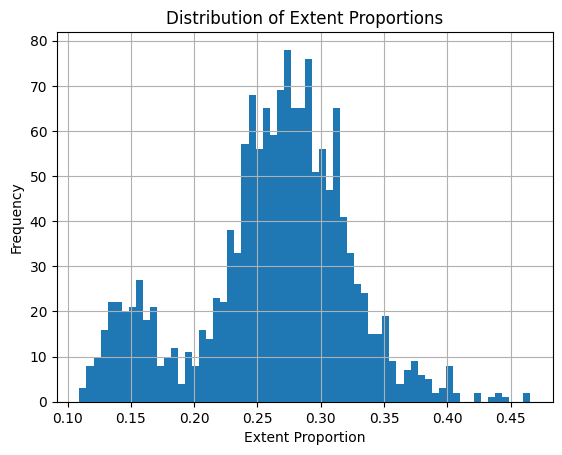

In [207]:
# get extent over resolution
extent_proportion = df['extent'] / df['shape'].apply(lambda x: x[0])

# distribution of extent proportions
extent_proportion.hist(bins=64)
plt.title("Distribution of Extent Proportions")
plt.xlabel("Extent Proportion")
plt.ylabel("Frequency")
plt.show()



We see that most of the masks have proportional extents that lie below 0.35-0.40.
We can assume that an extent of 0.35 + some extra pixels will be fine, or direclty get a ROI that extends 0.5 off the center.

Basically, we should crop less than a 0.55 of the image to be sure that no prostate is left behind. Also, since some might be off centered, whe might want to lower that number, and keep it around 0.4-0.3. We don't want to go too low since we are also aiming to reduce computational costs.